<a href="https://colab.research.google.com/github/lucas-t-reis/research/blob/master/boolean-networks/Boolean_Networks_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulação de Redes Booleanas

O presente *notebook* tem como objetivo explorar a simulação síncrona de redes booleanas, que são modeladas com base em sistemas biológicos e frequentemente servem de base para experimentos *in silico* que visam entender a dinâmica da interação entre genes, moléculas ou outros componentes que façam parte de sistemas biológicos. 

Sabendo que simular $N$ possíveis estados é uma tarefa de complexidade exponencial, visto que temos $2^{N}$ possíveis estados, faz-se necessário utilizar estratégias diminuam tempo de execução de execução. Como o principal objetivo das simulações é obter um conjunto de probabilidades associada a cada agente biológico estudado e a exploração dos estados da rede é independente de outros estados que não o anterior, este problema se torna candidato a otimização utilizando computação paralela.

# Dependencies

Plugins necessários para execução de código em CUDA com a *cell magic* `%%gpu`

In [ ]:
!pip install git+git://github.com/canesche/nvcc4jupyter.git
!git clone https://github.com/canesche/nvcc4jupyter
%load_ext nvcc_plugin

  Cloning git://github.com/canesche/nvcc4jupyter.git to /tmp/pip-req-build-wxdrcx1v
  Running command git clone -q git://github.com/canesche/nvcc4jupyter.git /tmp/pip-req-build-wxdrcx1v
  Created wheel for ColabPlugin: filename=ColabPlugin-blind-cp36-none-any.whl size=12717 sha256=a4fb316191c268b022732ba3ada05fe7d4a950c956c0d53ae77aac12470ecf34
  Stored in directory: /tmp/pip-ephem-wheel-cache-d1iow45r/wheels/87/ae/09/21c6e192181a0472e20ddd1d5212e2cbb113f00ebe14330d0d
Successfully built ColabPlugin
fatal: destination path 'nvcc4jupyter' already exists and is not an empty directory.
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


GPU utilizada nos experimentos

In [ ]:
!nvidia-smi

Thu Feb 11 19:22:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Neste arquivo de cabeçalho, se encontram:

- Macro de verificação de erros para GPU;
- Encapsulamento da implementação de um Cronômetro para CPU e para GPU;
- Função auxiliar para imprimir os tempos de cada execução em um arquivo `.csv`;
- Função auxiliar para imprimir o histograma obtido após as simulações;

In [ ]:
%%writefile profiler.h
#ifndef PROFILER_H
#define PROFILER_H

#include<chrono>
#include<fstream>

#define MAX_POWER10 10

//Macro for checking cuda errors following a cuda launch or api call
#define cudaCheckError() {                                                      \
 cudaError_t e=cudaGetLastError();                                              \
 if(e!=cudaSuccess) {                                                           \
   printf("Cuda failure %s:%d: '%s'\n",__FILE__,__LINE__,cudaGetErrorString(e));\
   exit(0);                                                                     \
 }                                                                              \
}

class CPU_Stopwatch {
    
    typedef std::chrono::steady_clock clock;
    
    private:
      std::chrono::time_point<clock> start;

    public:
      void reset() { start = clock::now(); }
      CPU_Stopwatch() { reset(); }
      auto stop() { 
          std::chrono::duration<float> elapsed_time = clock::now() - start;
          return elapsed_time.count() * 1000;
      }
};

class GPU_Stopwatch {
    
    private:
      cudaEvent_t start;
      cudaEvent_t end;

    public:
      GPU_Stopwatch() {
          
          cudaEventCreate(&start);
          cudaEventCreate(&end);
          
          cudaEventRecord(start);
      }
      float stop() {

          cudaEventRecord(end);

          cudaEventSynchronize(end);
          float milliseconds = -1;
          cudaEventElapsedTime(&milliseconds, start, end);

          return milliseconds;

      }
    
};

void write_csv(const char * fileName, float profiling_times[], size_t n) {
    
    std::ofstream csv(fileName, std::ofstream::out);
    for(int i=0; i<n; i++) {
      if(i==n-1)
        csv << profiling_times[i] << "\n";
      else
        csv << profiling_times[i] << ",";    
    }    
}

void print_histogram(int *histogram, size_t n) {
    printf("Histogram [");
    for(int i=0; i<n; i++) {
        if(i==n-1) printf("%d]", histogram[i]);
        else printf("%d,", histogram[i]);
    }
}

#endif

Overwriting profiler.h


# Node activation estimation based on Simulation

## CPU
Baseline para comparação do tempo de execução em GPU. 

- network.h - Equações booleanas, função de inicialização do estado dos nós e array da rede, bem como o *define* com o tamanho da mesma. Este arquivo deve ser gerado para cada rede, contendo suas respectivas equações convertidas para um formato aceito em C/C++.

- source - Código com implementação usando pointeiros para função. A cada passo o histograma e o estado da rede é atualizado dentro do *loop* principal.

In [ ]:
%%writefile network_cpu.h

#ifndef NETWORK_CPU_H
#define NETWORK_CPU_H

#define N 10
bool network_state[N];

// ---------- BOOLEAN NETWORK FUNCTIONS ---------- //
bool Cdc25(){ return  !network_state[3] && network_state[1] ||  !network_state[3] && network_state[0] || network_state[1] && network_state[0]; }
bool Cdc2_Cdc13(){ return  !network_state[7] &&  !network_state[6] &&  !network_state[4]; }
bool Cdc2_Cdc13_A(){ return  !network_state[8] &&  !network_state[7] &&  !network_state[6] &&  !network_state[4] && network_state[0]; }
bool PP(){ return network_state[6]; }
bool Rum1(){ return  !network_state[5] && network_state[4] && network_state[3] &&  !network_state[2] ||  !network_state[5] && network_state[4] && network_state[3] &&  !network_state[1] ||  !network_state[5] && network_state[4] &&  !network_state[2] &&  !network_state[1] ||  !network_state[5] && network_state[3] &&  !network_state[2] &&  !network_state[1] || network_state[4] && network_state[3] &&  !network_state[2] &&  !network_state[1]; }
bool SK(){ return network_state[9]; }
bool Slp1(){ return network_state[2]; }
bool Ste9(){ return network_state[7] &&  !network_state[5] && network_state[3] &&  !network_state[2] || network_state[7] &&  !network_state[5] && network_state[3] &&  !network_state[1] || network_state[7] &&  !network_state[5] &&  !network_state[2] &&  !network_state[1] || network_state[7] && network_state[3] &&  !network_state[2] &&  !network_state[1] ||  !network_state[5] && network_state[3] &&  !network_state[2] &&  !network_state[1]; }
bool Wee1_Mik1(){ return network_state[8] && network_state[3] || network_state[8] &&  !network_state[1] || network_state[3] &&  !network_state[1]; }
bool Start(){ return true; }

char names[N][26] = {"Cdc25","Cdc2_Cdc13","Cdc2_Cdc13_A","PP","Rum1","SK","Slp1","Ste9","Wee1_Mik1","Start"};
bool (*node_function[10])();

void initializeFunctions() {
	node_function[0] = Cdc25;
	node_function[1] = Cdc2_Cdc13;
	node_function[2] = Cdc2_Cdc13_A;
	node_function[3] = PP;
	node_function[4] = Rum1;
	node_function[5] = SK;
	node_function[6] = Slp1;
	node_function[7] = Ste9;
	node_function[8] = Wee1_Mik1;
	node_function[9] = Start;
}

// Nodes with fixed state
void initializeNodes() {

    network_state[9] = true;

}
#endif

Overwriting network_cpu.h


In [ ]:
%%gpu

#include <string.h>
#include <stdbool.h>
#include <stdio.h>

#include "network_cpu.h"
#include "profiler.h"

bool next_state[N];
int histogram[N];

int main() {
	
	size_t n_bytes = sizeof(bool) * N;
    
	
	initializeFunctions();
	initializeNodes();

    float elapsed_time[MAX_POWER10];
    unsigned long long iterations = 10;
    for(int t=0; t<MAX_POWER10; t++) {
        memset(network_state,	0, n_bytes);
        memset(histogram,		0.0, sizeof(double)*N);
        CPU_Stopwatch s;
        for(unsigned long long i=0; i<iterations; i++) {
    
            #pragma unroll
            for(int j=0; j<N; j++) { next_state[j] = node_function[j](); }
            
            // Update the whole network after processing every node
            memcpy(network_state, next_state, n_bytes);
            
            #pragma unroll
            for(int j=0; j<N; j++) { histogram[j] += network_state[j]; } 
    
        }

        elapsed_time[t] = s.stop();
        printf("it:%llu\ttime:%f\n", iterations, elapsed_time[t]);
        iterations*=10;
    }

    //print_histogram(histogram, N);
    write_csv("CPU.csv", elapsed_time, MAX_POWER10);

return 0;

}

it:10	time:0.001678
it:100	time:0.005930
it:1000	time:0.054047
it:10000	time:0.615304
it:100000	time:5.463833
it:1000000	time:54.264389
it:10000000	time:547.754272
it:100000000	time:5521.171875
it:1000000000	time:55196.675781
it:10000000000	time:550134.562500



## GPU

### Naive State Array

Implementação que serve de Baseline para as técnicas de otimização em GPU.

- Código do **kernel** é gerado para um grafo específico;

- Utilização de *array* para representação dos estados e armazenamento do histograma;

- Número de iterações dividido entre *threads* utilizadas;



In [ ]:
%%gpu
#include <string.h>
#include <stdbool.h>
#include <stdio.h>


#include "profiler.h"

#define ITERATIONS 8
#define N 10

__global__
void simulate(int iterations, bool *state, bool *next_state, int *histogram) {

    int tId = threadIdx.x + blockDim.x*blockIdx.x;
    if(tId >= N) return;

    int offset = tId*N;
    
    // Constants
    state[offset+9] = true;
    for(int i=0; i<iterations; i++) {
        
        next_state[offset+0] =  ! state[offset+3] & state[offset+1] |  ! state[offset+3] & state[offset+0] | state[offset+1] & state[offset+0];
        next_state[offset+1] =  ! state[offset+7] &  ! state[offset+6] &  ! state[offset+4];
        next_state[offset+2] =  ! state[offset+8] &  ! state[offset+7] &  ! state[offset+6] &  ! state[offset+4] & state[offset+0];
        next_state[offset+3] = state[offset+6];
        next_state[offset+4] =  ! state[offset+5] & state[offset+4] & state[offset+3] &  ! state[offset+2] |  ! state[offset+5] & state[offset+4] & state[offset+3] &  ! state[offset+1] |  ! state[offset+5] & state[offset+4] &  ! state[offset+2] &  ! state[offset+1] |  ! state[offset+5] & state[offset+3] &  ! state[offset+2] &  ! state[offset+1] | state[offset+4] & state[offset+3] &  ! state[offset+2] &  ! state[offset+1];
        next_state[offset+5] =  state[offset+9];
        next_state[offset+6] = state[offset+2];
        next_state[offset+7] = state[offset+7] &  ! state[offset+5] & state[offset+3] &  ! state[offset+2] | state[offset+7] &  ! state[offset+5] & state[offset+3] &  ! state[offset+1] | state[offset+7] &  ! state[offset+5] &  ! state[offset+2] &  ! state[offset+1] | state[offset+7] & state[offset+3] &  ! state[offset+2] &  ! state[offset+1] |  ! state[offset+5] & state[offset+3] &  ! state[offset+2] &  ! state[offset+1];
        next_state[offset+8] = state[offset+8] & state[offset+3] | state[offset+8] &  ! state[offset+1] | state[offset+3] &  ! state[offset+1];
        next_state[offset+9] = state[offset+9];
        
        #pragma unroll
        for(int j=0; j<N; j++) 
            state[offset+j] = next_state[offset+j];
        
        #pragma unroll
        for(int j=0; j<N; j++)
            histogram[offset+j] += state[offset+j];

    }

}

int main() {
	
    // Kernel variables
    int threads = 128; 
    int blocks = (N+threads-1)/threads;

    size_t n_bytes = sizeof(bool) * N * threads;
    size_t hist_bytes = sizeof(int) * N * threads;
   
    bool *d_state, *d_next_state;
    int *d_histogram;
    cudaMalloc((void**) &d_state, n_bytes);
    cudaMalloc((void**) &d_next_state, n_bytes);
    cudaMalloc((void**) &d_histogram, hist_bytes);
    printf("blocks%d\n", blocks);
    float elapsed_time[MAX_POWER10];
    unsigned long long iterations = 10;
    for(int t=0; t<MAX_POWER10; t++) {
        cudaMemset(d_state, 0, n_bytes);
        cudaMemset(d_histogram, 0, hist_bytes);

        GPU_Stopwatch s;
        int split_workload = iterations / (blocks*threads) + 1;
        simulate <<< blocks, threads >>> (split_workload, d_state, d_next_state, d_histogram);
        elapsed_time[t] = s.stop();
        printf("it:%llu\t\tsplit_wload:%d\t\ttime:%f\n", iterations, split_workload, elapsed_time[t]);

        iterations *= 10;
    }

    cudaDeviceSynchronize();
    write_csv("GPU_naive.csv", elapsed_time, MAX_POWER10);

    // Host variables
    int *h_histogram;
    h_histogram = (int*) malloc(hist_bytes);
    cudaMemcpy(h_histogram, d_histogram, hist_bytes, cudaMemcpyDeviceToHost);

    return 0;
}

blocks1
it:10		split_wload:1		time:0.027712
it:100		split_wload:1		time:0.011072
it:1000		split_wload:8		time:0.036864
it:10000		split_wload:79		time:0.317984
it:100000		split_wload:782		time:3.038976
it:1000000		split_wload:7813		time:30.254240
it:10000000		split_wload:78126		time:291.692078
it:100000000		split_wload:781251		time:2712.581787
it:1000000000		split_wload:7812501		time:27118.742188
it:10000000000		split_wload:78125001		time:271189.093750



### GPU Sate Array  and Shared Memory

Implementação semelhante ao *baseline*, com a adição de:

- Memória compartilhada para manipulação dos estados e histograma pelas *threads*

- Utilização reduzida da *global memory*

In [ ]:
%%gpu
#include <string.h>
#include <stdbool.h>
#include <stdio.h>


#include "profiler.h"

#define THREADS 128 
#define BLOCKS 1
#define N 10

__global__
void simulate(int iterations, bool *state, bool *next_state, int *histogram) {

    int tId = threadIdx.x + blockDim.x*blockIdx.x;
    if(tId >= N) return;
    
    __shared__ bool shared_state[THREADS*BLOCKS*(N+1)]; // +1 for padding
    __shared__ bool temp_state[THREADS*BLOCKS*(N+1)];
    __shared__ bool shared_hist[THREADS*BLOCKS*(N+1)];

    int offset = tId*(N+1);
    
    // Constants
    state[offset+9] = true;
    shared_state[offset+9] = true;

    #pragma unroll
    for(int i=0; i<iterations; i++) {

        temp_state[offset+0] =  ! shared_state[offset+3] & shared_state[offset+1] |  ! shared_state[offset+3] & shared_state[offset+0] | shared_state[offset+1] & shared_state[offset+0];
        temp_state[offset+1] =  ! shared_state[offset+7] &  ! shared_state[offset+6] &  ! shared_state[offset+4];
        temp_state[offset+2] =  ! shared_state[offset+8] &  ! shared_state[offset+7] &  ! shared_state[offset+6] &  ! shared_state[offset+4] & shared_state[offset+0];
        temp_state[offset+3] = shared_state[offset+6];
        temp_state[offset+4] =  ! shared_state[offset+5] & shared_state[offset+4] & shared_state[offset+3] &  ! shared_state[offset+2] |  ! shared_state[offset+5] & shared_state[offset+4] & shared_state[offset+3] &  ! shared_state[offset+1] |  ! shared_state[offset+5] & shared_state[offset+4] &  ! shared_state[offset+2] &  ! shared_state[offset+1] |  ! shared_state[offset+5] & shared_state[offset+3] &  ! shared_state[offset+2] &  ! shared_state[offset+1] | shared_state[offset+4] & shared_state[offset+3] &  ! shared_state[offset+2] &  ! shared_state[offset+1];
        temp_state[offset+5] =  shared_state[offset+9];
        temp_state[offset+6] = shared_state[offset+2];
        temp_state[offset+7] = shared_state[offset+7] &  ! shared_state[offset+5] & shared_state[offset+3] &  ! shared_state[offset+2] | shared_state[offset+7] &  ! shared_state[offset+5] & shared_state[offset+3] &  ! shared_state[offset+1] | shared_state[offset+7] &  ! shared_state[offset+5] &  ! shared_state[offset+2] &  ! shared_state[offset+1] | shared_state[offset+7] & shared_state[offset+3] &  ! shared_state[offset+2] &  ! shared_state[offset+1] |  ! shared_state[offset+5] & shared_state[offset+3] &  ! shared_state[offset+2] &  ! shared_state[offset+1];
        temp_state[offset+8] = shared_state[offset+8] & state[offset+3] | state[offset+8] &  ! state[offset+1] | state[offset+3] &  ! state[offset+1];
        temp_state[offset+9] = shared_state[offset+9]; 

        #pragma unroll
        for(int j=0; j<N; j++) 
            shared_state[offset+j] = temp_state[offset+j];
        
        #pragma unroll
        for(int j=0; j<N; j++)
            shared_hist[offset+j] += shared_state[offset+j];

    }
    
    #pragma unroll
    for(int j=0; j<N; j++) 
        state[offset+j] = shared_state[offset+j];
    
    #pragma unroll
    for(int j=0; j<N; j++)
        histogram[offset+j] += shared_hist[offset+j];


}

int main() {
	
    // Kernel variables
    int threads = THREADS;
    int blocks = (N+threads-1)/threads;

    size_t n_bytes = sizeof(bool) * N * threads;
    size_t hist_bytes = sizeof(int) * N * threads;
   
    bool *d_state, *d_next_state;
    int *d_histogram;
    cudaMalloc((void**) &d_state, n_bytes);
    cudaMalloc((void**) &d_next_state, n_bytes);
    cudaMalloc((void**) &d_histogram, hist_bytes);
    printf("blocks%d\n", blocks);
    float elapsed_time[MAX_POWER10];
    unsigned long long iterations = 10;
    for(int t=0; t<MAX_POWER10; t++) {
        cudaMemset(d_state, 0, n_bytes);
        cudaMemset(d_histogram, 0, hist_bytes);

        GPU_Stopwatch s;
        int split_workload = iterations / (blocks*threads) + 1;
        simulate <<< blocks, threads >>> (split_workload, d_state, d_next_state, d_histogram);
        elapsed_time[t] = s.stop();
        printf("it:%llu\t\tsplit_wload:%d\t\ttime:%f\n", iterations, split_workload, elapsed_time[t]);

        iterations *= 10;
    }

    cudaDeviceSynchronize();
    write_csv("GPU_state.csv", elapsed_time, MAX_POWER10);

    // Host variables
    int *h_histogram;
    h_histogram = (int*) malloc(hist_bytes);
    cudaMemcpy(h_histogram, d_histogram, hist_bytes, cudaMemcpyDeviceToHost);

    return 0;
}

blocks1
it:10		split_wload:1		time:0.020736
it:100		split_wload:1		time:0.013248
it:1000		split_wload:8		time:0.007648
it:10000		split_wload:79		time:0.024576
it:100000		split_wload:782		time:0.134304
it:1000000		split_wload:7813		time:1.229952
it:10000000		split_wload:78126		time:12.240096
it:100000000		split_wload:781251		time:122.330788
it:1000000000		split_wload:7812501		time:1223.247437
it:10000000000		split_wload:78125001		time:12232.322266



### GPU Function Pointers, Shared Memory and Registers

Nesta estratégia, foi utilizado:

- Conversão de equações booleanas em funções;

- Ponteiro de funções;

- Memória compartilhada para manipulação dos estados da rede;

- Controle de concorrência com função de escrita `atomicAdd(...)`

In [ ]:
%%writefile network.h

#ifndef NETWORK_H
#define NETWORK_H

#define N 10
typedef bool (*cuda_func)(bool *);

// ---------- BOOLEAN NETWORK FUNCTIONS ---------- //
__device__ bool Cdc25(bool *network_state){ return  !network_state[3] && network_state[1] ||  !network_state[3] && network_state[0] || network_state[1] && network_state[0]; }
__device__ bool Cdc2_Cdc13(bool *network_state){ return  !network_state[7] &&  !network_state[6] &&  !network_state[4]; }
__device__ bool Cdc2_Cdc13_A(bool *network_state){ return  !network_state[8] &&  !network_state[7] &&  !network_state[6] &&  !network_state[4] && network_state[0]; }
__device__ bool PP(bool *network_state){ return network_state[6]; }
__device__ bool Rum1(bool *network_state){ return  !network_state[5] && network_state[4] && network_state[3] &&  !network_state[2] ||  !network_state[5] && network_state[4] && network_state[3] &&  !network_state[1] ||  !network_state[5] && network_state[4] &&  !network_state[2] &&  !network_state[1] ||  !network_state[5] && network_state[3] &&  !network_state[2] &&  !network_state[1] || network_state[4] && network_state[3] &&  !network_state[2] &&  !network_state[1]; }
__device__ bool SK(bool *network_state){ return network_state[9]; }
__device__ bool Slp1(bool *network_state){ return network_state[2]; }
__device__ bool Ste9(bool *network_state){ return network_state[7] &&  !network_state[5] && network_state[3] &&  !network_state[2] || network_state[7] &&  !network_state[5] && network_state[3] &&  !network_state[1] || network_state[7] &&  !network_state[5] &&  !network_state[2] &&  !network_state[1] || network_state[7] && network_state[3] &&  !network_state[2] &&  !network_state[1] ||  !network_state[5] && network_state[3] &&  !network_state[2] &&  !network_state[1]; }
__device__ bool Wee1_Mik1(bool *network_state){ return network_state[8] && network_state[3] || network_state[8] &&  !network_state[1] || network_state[3] &&  !network_state[1]; }
__device__ bool Start(bool *network_state){ return true; }

__device__ cuda_func f1 = Cdc25;
__device__ cuda_func f2 = Cdc2_Cdc13;
__device__ cuda_func f3 = Cdc2_Cdc13_A;
__device__ cuda_func f4 = PP;
__device__ cuda_func f5 = Rum1;
__device__ cuda_func f6 = SK;
__device__ cuda_func f7 = Slp1;
__device__ cuda_func f8 = Ste9;
__device__ cuda_func f9 = Wee1_Mik1;
__device__ cuda_func f10 = Start;

char names[N][26] = {"Cdc25","Cdc2_Cdc13","Cdc2_Cdc13_A","PP","Rum1","SK","Slp1","Ste9","Wee1_Mik1","Start"};

#endif

In [ ]:
%%gpu

#include <string.h>
#include <stdbool.h>
#include <stdio.h>

#include "network.h"
#include "profiler.h"


#define THREADS 32
#define BLOCKS 128

__global__ void simulate(int iterations, cuda_func* f, bool *network_state, bool *next_state, int *histogram) {

    int tId = blockDim.x*blockIdx.x + threadIdx.x;
    __shared__ bool shared_state[THREADS*BLOCKS*(N+1)];

    int offset = tId*(N+1); 

    for(int i=0; i<iterations; i++) {

        bool state = f[0](shared_state);
        bool state1 = f[1](shared_state);
        bool state2 = f[2](shared_state);
        bool state3 = f[3](shared_state);
        bool state4 = f[4](shared_state);
        bool state5 = f[5](shared_state);
        bool state6 = f[6](shared_state);
        bool state7 = f[7](shared_state);
        bool state8 = f[8](shared_state);
        bool state9 = f[9](shared_state);
    
        shared_state[offset+0] = state;
        shared_state[offset+1] = state1;
        shared_state[offset+2] = state2;
        shared_state[offset+3] = state3;
        shared_state[offset+4] = state4;
        shared_state[offset+5] = state5;
        shared_state[offset+6] = state6;
        shared_state[offset+7] = state7;
        shared_state[offset+8] = state8;
        shared_state[offset+9] = state9;
        
        atomicAdd(&histogram[0], state);
        atomicAdd(&histogram[1], state1);
        atomicAdd(&histogram[2], state2);
        atomicAdd(&histogram[3], state3);
        atomicAdd(&histogram[4], state5);
        atomicAdd(&histogram[5], state5);
        atomicAdd(&histogram[6], state6);
        atomicAdd(&histogram[7], state7);
        atomicAdd(&histogram[8], state8);
        atomicAdd(&histogram[9], state9);
    }
}

__global__
void initializeNodes(bool *network_state){
    network_state[9] = true;
}

int main() {

    size_t n_bytes = sizeof(bool) * N;
    
    // Initializing array from network header file
    bool *network_state;
    cudaMalloc((void **) &network_state, n_bytes);

    // Auxiliary arrays
    bool *next_state;
    cudaMalloc((void **) &next_state, n_bytes);
    
    int *histogram;
    size_t hist_bytes = sizeof(int)*N;
    cudaMalloc((void**) &histogram, hist_bytes);
    cudaMemset(histogram, 0, hist_bytes);

    // Function pointer arrays
    cuda_func *h_f;
    cuda_func *d_f;
    size_t func_bytes = N * sizeof(cuda_func);
    h_f = (cuda_func*) malloc(func_bytes);
    cudaMalloc((void**) &d_f, func_bytes);

    cudaMemcpyFromSymbol( &h_f[0], f1, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[1], f2, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[2], f3, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[3], f4, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[4], f5, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[5], f6, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[6], f7, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[7], f8, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[8], f9, sizeof(cuda_func) );
    cudaMemcpyFromSymbol( &h_f[9], f10, sizeof(cuda_func) );

    cudaMemcpy(d_f, h_f, func_bytes, cudaMemcpyHostToDevice);

    initializeNodes<<<1,1>>>(network_state);
    
    // ---------- SIMULATION ---------- //
    float elapsed_time[MAX_POWER10];
    unsigned long long iterations = 10;
    for(int t=0; t<MAX_POWER10; t++){
        
        int threads = 128;
        int blocks = (N+iterations+threads-1)/threads;
        
        cudaMemset(network_state, 0, n_bytes);
        cudaMemset(histogram, 0, hist_bytes);
        
        GPU_Stopwatch s;
        int split_workload = iterations / (BLOCKS*THREADS) + 1;
        simulate<<< BLOCKS, THREADS >>>(split_workload, d_f, network_state, next_state, histogram);
        cudaMemcpy(network_state, next_state, n_bytes, cudaMemcpyDeviceToDevice);
        
        elapsed_time[t] = s.stop();
        printf("it:%llu\tblocks:%d\ttime:%f\n", iterations, blocks, elapsed_time[t]);

       
        iterations *= 10;
    }
    cudaDeviceSynchronize();
    write_csv("GPU_func.csv", elapsed_time, MAX_POWER10);
    cudaCheckError();
    
    int *h_histogram;
    h_histogram = (int*) malloc(hist_bytes);
    cudaMemcpy(h_histogram, histogram, hist_bytes, cudaMemcpyDeviceToHost);

    //print_histogram(h_histogram, N);
}

it:10	blocks:1	time:0.031232
it:100	blocks:1	time:0.026464
it:1000	blocks:8	time:0.027488
it:10000	blocks:79	time:0.063648
it:100000	blocks:782	time:0.467040
it:1000000	blocks:7813	time:4.454944
it:10000000	blocks:78126	time:44.532543
it:100000000	blocks:781251	time:443.096924
it:1000000000	blocks:7812501	time:4450.744629
it:10000000000	blocks:78125001	time:44359.738281



 # Analysing

In [ ]:
# Fetching data from GPU and CPU benchmarks
cpu = []
gpu_naive= []
gpu_state= []
gpu_func = []

i = 0
with open("CPU.csv", "r") as file:
  for value in file.readline().split(","):
    if i<4:
        i += 1
        continue  
    cpu.append(float(value)/1000)

i = 0
with open("GPU_naive.csv", "r") as file:
  for value in file.readline().split(","):
    if i<4:
        i += 1
        continue  
    gpu_naive.append(float(value)/1000)

i = 0
with open("GPU_state.csv", "r") as file:
  for value in file.readline().split(","):
    if i<4:
        i += 1
        continue  
    gpu_state.append(float(value)/1000)

i = 0
with open("GPU_func.csv", "r") as file:
  for value in file.readline().split(","):
    if i<4:
        i += 1
        continue  
    gpu_func.append(float(value)/1000)



## Resultados
No gráfico abaixo, podemos notar que a estratégia que utilizou array de estados pré-compilado em conjunto com memória compartilhada foi a que obteve melhor desempenho, seguida dos ponteiros de função, da implementação *naive* em GPU e da implementação da simulação em CPU.

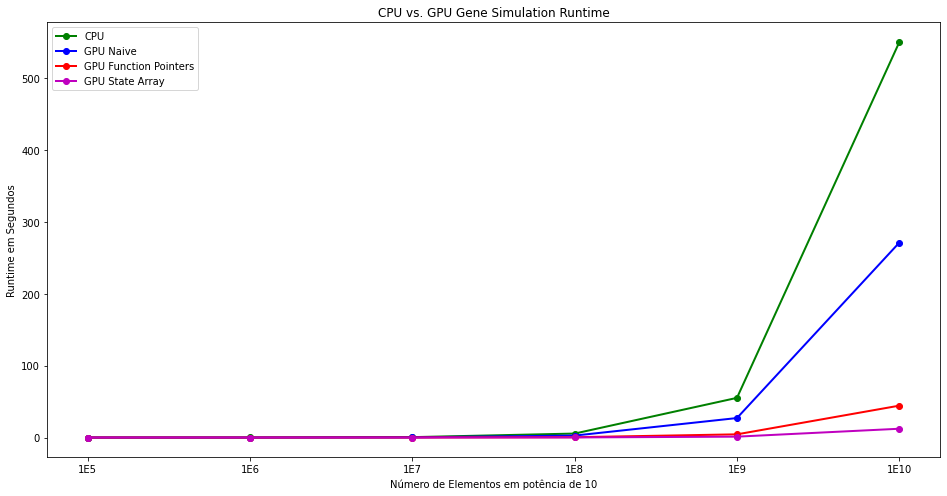

In [ ]:
import matplotlib.pyplot as plt

# Number of elements utilized
labels = ["1E5", "1E6", "1E7", "1E8", "1E9", "1E10"]

# Graph plotting settings
plt.figure(figsize=(16,8))

plt.plot(labels, cpu, 'go-', linewidth=2, label="CPU")
plt.plot(gpu_naive, 'bo-', linewidth=2, label="GPU Naive")
plt.plot(gpu_func, 'ro-', linewidth=2, label="GPU Function Pointers")
plt.plot(gpu_state, 'mo-', linewidth=2, label="GPU State Array")

plt.xlabel("Número de Elementos em potência de 10")
plt.ylabel("Runtime em Segundos")
plt.title("CPU vs. GPU Gene Simulation Runtime")
plt.legend(loc="upper left")

Abaixo segue a tabela de *speedup* aproximado do código comparado à CPU

GPU Strategy | Speedup
-------------|---------
Naive        |     2x
Function Pointers| 12x
State Array  |     45x


Observando a tabela acima, mesmo ao considerar a estratégia mais simples, fica clara a contribuição da utilização de GPUs para a Simulação de Redes Booleanas. Ainda que o resultado seja satisfatório, outras otimizações como a representação da rede em bits, *profiling* usando *nsight* e refatoração de código podem ser realizadas na presente implementação com intuito de alcançar ainda mais performance. Por fim, para trabalhos futuros é necessário tornar a geração de código pré-compilado simples e automática, de modo que esta ferramenta possa ser utilizada por pesquisadores da área sem necessidade de conhecimentos específicos.